# Football match prediction

In this experiment we are going to use the [Kaggle football dataset](https://www.kaggle.com/hugomathien/soccer). The dataset has information from +25,000 matches, +10,000 players from 11 European Countries with their lead championship during seasons 2008 to 2016. It also contains players attributes sourced from EA Sports' FIFA video game series.

The problem we address is to try to predict if a match is going to end as win, draw or defeat. 

Part of the code use in this notebook is this [kaggle kernel](https://www.kaggle.com/airback/match-outcome-prediction-in-football).

In [3]:
import os,sys
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, log_loss, precision_score, recall_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from libs.loaders import load_football
from libs.football import get_fifa_data, create_feables
from libs.timer import Timer
from libs.utils import get_number_processors
import pickle
import pkg_resources
import matplotlib.pylab as plt
import json

print("System version: {}".format(sys.version))
print("XGBoost version: {}".format(pkg_resources.get_distribution('xgboost').version))
print("LightGBM version: {}".format(pkg_resources.get_distribution('lightgbm').version))

%matplotlib inline


System version: 3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
XGBoost version: 0.6
LightGBM version: 0.2


## 1) XGBoost vs LightGBM benchmark

In the next section we compare both libraries speed, accuracy and other metrics for the football dataset.


### Data loading and management


In [4]:
%%time
countries, matches, leagues, teams, players = load_football()
print(countries.shape)
print(matches.shape)
print(leagues.shape)
print(teams.shape)
print(players.shape)

INFO:libs.loaders:MOUNT_POINT not found in environment. Defaulting to /fileshare


(11, 2)
(25979, 115)
(11, 3)
(299, 5)
(183978, 42)
CPU times: user 3.98 s, sys: 768 ms, total: 4.75 s
Wall time: 22.1 s


In [5]:
leagues

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [6]:
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [7]:
#Reduce match data to fulfill run time requirements
cols = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data = matches.dropna(subset = cols)
print(match_data.shape)


(21374, 115)


Now, using the information from the matches and players, we are going to create features based on the FIFA attributes. This computation is heavy, so we are going to save it the first time we create it.  

In [8]:
%%time
fifa_data_filename = 'fifa_data.pk'
if os.path.isfile(fifa_data_filename):
    fifa_data = pd.read_pickle(fifa_data_filename)
else:
    fifa_data = get_fifa_data(match_data, players)
    fifa_data.to_pickle(fifa_data_filename)
print(fifa_data.shape)


(21374, 23)
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 628 ms


Finally, we are going to compute the features and labels. The labels are related to the result of the team playing at home, they are: `Win`, `Draw`, `Defeat`. 

In [9]:
%%time
bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bk_cols_selected = ['B365', 'BW']      
feables = create_feables(match_data, fifa_data, bk_cols_selected, get_overall = True)
print(feables.shape)


Generating match features...
Generating match labels...
Generating bookkeeper data...


/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(19673, 48)
CPU times: user 14min 2s, sys: 2.56 s, total: 14min 4s
Wall time: 14min 16s


In [10]:
feables.head()

,match_api_id,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,season,League_1.0,League_1729.0,...,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,B365_Win,B365_Draw,B365_Defeat,BW_Win,BW_Draw,BW_Defeat,label
0,493017,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,1,0,...,70.0,68.0,63.0,0.313804,0.276886,0.409310,0.307825,0.279410,0.412765,Win
1,493025,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,1,0,...,67.0,73.0,68.0,0.327179,0.286281,0.386540,0.290493,0.300176,0.409331,Defeat
2,493027,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,1,0,...,55.0,58.0,64.0,0.672897,0.209346,0.117757,0.672269,0.226891,0.100840,Win
3,493034,1.0,2.0,1.0,1.0,0.0,0.0,2008.0,1,0,...,74.0,70.0,69.0,0.207407,0.259259,0.533333,0.192717,0.274476,0.532807,Win
4,493040,-2.0,0.0,0.0,0.0,0.0,0.0,2008.0,1,0,...,60.0,63.0,65.0,0.535211,0.267606,0.197183,0.565759,0.254990,0.179250,Draw


Let's now split features and labels.

In [11]:
features = feables[feables.columns.difference(['match_api_id', 'label'])]
labs = feables['label']
print(features.shape)
print(labs.shape)

(19673, 46)
(19673,)


Once we have the features and labels defined, let's create the train and test set.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, labs, test_size=0.2, random_state=42, stratify=labs)

### XGBoost analysis
Once we have done the feature engineering step, we can start to train with each of the libraries. We will start with XGBoost. 

We are going to save the training and test time, as well as some metrics. 

In [13]:
number_processors = get_number_processors()
print("Number of processors: ", number_processors)

Number of processors:  20


In [14]:
results_dict = dict()

In [15]:
clf = XGBClassifier(max_depth=3,
                    n_estimators=300,
                    min_child_weight=5,
                    learning_rate=0.1,
                    colsample_bytree=0.80,
                    scale_pos_weight=2,
                    gamma=0.1,
                    reg_lambda=1,
                    subsample=1,
                    n_jobs=number_processors)

In [16]:
with Timer() as t:
    clf.fit(X_train, y_train, verbose=False, eval_metric='merror')

In [17]:
results_dict['xgb']={
    'train_time': t.interval
}

In [18]:
with Timer()as t:
    y_pred = clf.predict(X_test)

In [19]:
results_dict['xgb']['test_time'] = t.interval

In [20]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_multilabel(y_true, y_pred, labels):
    m_acc = accuracy_score(y_true, y_pred)
    m_f1 = f1_score(y_true, y_pred, labels, average='weighted')
    m_precision = precision_score(y_true, y_pred, labels, average='weighted')
    m_recall = recall_score(y_true, y_pred, labels, average='weighted')
    report = {'Accuracy':m_acc, 'Precision':m_precision, 'Recall':m_recall, 'F1':m_f1}
    return report

In [21]:
labels = ["Win", "Draw", "Defeat"]
report = classification_metrics_multilabel(y_test, y_pred, labels)

In [22]:
results_dict['xgb']['performance'] = report

In [23]:
clf = XGBClassifier(max_depth=0,
                    n_estimators=300,
                    min_child_weight=5,
                    learning_rate=0.1,
                    colsample_bytree=0.80,
                    scale_pos_weight=2,
                    gamma=0.1,
                    reg_lambda=1,
                    subsample=1,
                    max_leaves=2**3,
                    grow_policy='lossguide',
                    tree_method='hist',
                    n_jobs=number_processors)

In [24]:
with Timer() as t:
    clf.fit(X_train, y_train, verbose=False, eval_metric='merror')

In [25]:
results_dict['xgb_hist']={
    'train_time': t.interval
}

In [26]:
with Timer()as t:
    y_pred = clf.predict(X_test)

In [27]:
results_dict['xgb_hist']['test_time'] = t.interval

In [28]:
report = classification_metrics_multilabel(y_test, y_pred, labels)

In [29]:
results_dict['xgb_hist']['performance'] = report

### LightGBM analysis

Now let's compare with LightGBM.

In [30]:
clf = LGBMClassifier(num_leaves=2**3,
                      n_estimators=300,
                      min_child_weight=5,
                      learning_rate=0.1,
                      colsample_bytree=0.80,
                      scale_pos_weight=2,
                      min_split_gain=0.1,
                      reg_lambda=1,
                      subsample=1,
                      nthread=number_processors)

In [31]:
with Timer()as t:
    clf.fit(X_train, y_train, verbose=False, eval_metric='multi_error')

In [32]:
results_dict['lgbm']={
    'train_time': t.interval
}

In [33]:
with Timer() as t:
    y_pred = clf.predict(X_test)

In [34]:
results_dict['lgbm']['test_time'] = t.interval

In [35]:
report = classification_metrics_multilabel(y_test, y_pred, labels)

In [36]:
results_dict['lgbm']['performance'] = report

Finally, the results.

In [37]:
# Results
print(json.dumps(results_dict, indent=4, sort_keys=True))

{
    "lgbm": {
        "performance": {
            "Accuracy": 0.5273189326556544,
            "F1": 0.4594968503939465,
            "Precision": 0.4627647374365573,
            "Recall": 0.5273189326556544
        },
        "test_time": 0.022209000992006622,
        "train_time": 0.5861983909999253
    },
    "xgb": {
        "performance": {
            "Accuracy": 0.5285895806861499,
            "F1": 0.4581501758019101,
            "Precision": 0.4728104942149788,
            "Recall": 0.5285895806861499
        },
        "test_time": 0.023160384997026995,
        "train_time": 3.1644887360016583
    },
    "xgb_hist": {
        "performance": {
            "Accuracy": 0.5285895806861499,
            "F1": 0.46087114582653593,
            "Precision": 0.4747655220586142,
            "Recall": 0.5285895806861499
        },
        "test_time": 0.013042542996117845,
        "train_time": 2.847534304004512
    }
}


As it can be seen, in the case of multilabel LightGBM is faster than XGBoost in both versions. The performance metrics are really poor, so we wouldn't recommend to bet based on this algorithm :-)

## 2) Concept drift

In this section we are trying to find concept drift in the dataset to check if retraining is valuable.

### Data management

For this experiment we are going to focus in just one league. We selected the Spanish league _La Liga_, which is the one that shows the highest concept drift. 

In [38]:
la_liga_id = 21518
matches_target = matches[matches['league_id'] == la_liga_id]
print(matches_target.shape)
matches_target.head(5)


(3040, 115)


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
21517,21518,21518,21518,2008/2009,1,2008-08-30 00:00:00,530023,10267,8661,3,...,5.00,1.65,3.40,4.50,1.75,3.30,5.00,1.67,3.40,5.00
21518,21519,21518,21518,2008/2009,1,2008-08-31 00:00:00,530084,8371,10205,1,...,2.60,2.90,3.20,2.25,2.75,3.20,2.50,2.80,3.25,2.30
21519,21520,21518,21518,2008/2009,1,2008-08-31 00:00:00,530085,9783,8633,2,...,1.90,3.25,3.25,2.00,3.50,3.20,2.10,3.25,3.25,2.10
21520,21521,21518,21518,2008/2009,1,2008-08-31 00:00:00,530086,8388,8634,1,...,1.57,7.00,3.75,1.45,6.50,3.75,1.53,5.50,3.75,1.53
21521,21522,21518,21518,2008/2009,1,2008-08-31 00:00:00,530087,8696,8302,1,...,2.30,2.70,3.10,2.40,2.75,3.25,2.45,2.70,3.25,2.38


In [39]:
cols = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data = matches_target.dropna(subset = cols)
print(match_data.shape)

(2707, 115)


In [40]:
%%time
fifa_data = get_fifa_data(match_data, players)

CPU times: user 4min 2s, sys: 960 ms, total: 4min 3s
Wall time: 4min 7s


In [41]:
pd.set_option('display.max_columns', None) #show all columns in pandas

In [42]:
print(fifa_data.shape)
fifa_data.head()

(2707, 23)


,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,home_player_4_overall_rating,home_player_5_overall_rating,home_player_6_overall_rating,home_player_7_overall_rating,home_player_8_overall_rating,home_player_9_overall_rating,home_player_10_overall_rating,home_player_11_overall_rating,away_player_1_overall_rating,away_player_2_overall_rating,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,match_api_id
21517,65.0,80.0,82.0,79.0,76.0,80.0,79.0,67.0,85.0,68.0,89.0,67.0,74.0,71.0,76.0,72.0,71.0,76.0,76.0,78.0,74.0,77.0,530023.0
21518,75.0,63.0,71.0,65.0,68.0,73.0,74.0,72.0,70.0,71.0,68.0,78.0,73.0,73.0,77.0,80.0,80.0,75.0,84.0,79.0,77.0,78.0,530084.0
21519,74.0,65.0,76.0,78.0,74.0,69.0,74.0,77.0,79.0,71.0,75.0,91.0,85.0,84.0,80.0,75.0,80.0,83.0,77.0,82.0,84.0,86.0,530085.0
21521,79.0,74.0,82.0,56.0,57.0,79.0,79.0,68.0,74.0,82.0,72.0,82.0,76.0,81.0,68.0,77.0,83.0,74.0,80.0,78.0,83.0,86.0,530087.0
21523,64.0,79.0,68.0,67.0,65.0,77.0,63.0,79.0,73.0,69.0,76.0,71.0,74.0,75.0,73.0,71.0,74.0,72.0,76.0,72.0,72.0,70.0,530089.0


In [43]:
%%time
bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bk_cols_selected = ['B365', 'BW']      
feables = create_feables(match_data, fifa_data, bk_cols_selected, get_overall = True, all_leagues = False)
print(feables.shape)
feables.head()

Generating match features...
Generating match labels...
Generating bookkeeper data...


/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(2706, 38)
CPU times: user 1min 48s, sys: 316 ms, total: 1min 49s
Wall time: 1min 51s


We are going to split the dataset into three groups: first seasons from 2008 until 2014. This will be our base dataset. Then we will create two more, one for season 2014/2015 and another for 2014/2015.

In [44]:
feables_rest = feables[(feables['season'] != 2014) & (feables['season'] != 2015)]
print(feables_rest.shape)
feables_2014_2015 = feables[feables['season'] == 2014]
print(feables_2014_2015.shape)
feables_2015_2016 = feables[feables['season'] == 2015]
print(feables_2015_2016.shape)

(1991, 38)
(364, 38)
(351, 38)


In [45]:
X_train = feables_rest[feables_rest.columns.difference(['match_api_id', 'label', 'season'])]
y_train = feables_rest['label']
X_test1 = feables_2014_2015[feables_rest.columns.difference(['match_api_id', 'label', 'season'])]
y_test1 = feables_2014_2015['label']
X_test2 = feables_2015_2016[feables_rest.columns.difference(['match_api_id', 'label', 'season'])]
y_test2 = feables_2015_2016['label']

print(X_train.shape)
print(X_test1.shape)
print(X_test2.shape)

(1991, 35)
(364, 35)
(351, 35)


In [46]:
feables_up_to_2014_2015 = feables[feables['season'] != 2015]
print(feables_up_to_2014_2015.shape)
X_train2 = feables_up_to_2014_2015[feables_up_to_2014_2015.columns.difference(['match_api_id', 'label', 'season'])]
y_train2 = feables_up_to_2014_2015['label']

(2355, 38)


### Analysis with XGBoost

To identify concept drift we need to find a difference in performance over time. First, we are going to train a classifier on the base dataset and predict on the seasons 2014/2015 and 2014/2015.

In [47]:
clf = XGBClassifier(max_depth=8, 
                    learning_rate=0.1, 
                    scale_pos_weight=2,
                    min_child_weight=5,
                    n_estimators=100,
                    subsample=1)

In [48]:
%%time
clf.fit(X_train, y_train, verbose=True, eval_metric='merror')

CPU times: user 2.34 s, sys: 36 ms, total: 2.37 s
Wall time: 2.53 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=0, silent=True,
       subsample=1)

In [49]:
y_pred1 = clf.predict(X_test1)
acc_xgb1 = accuracy_score(y_test1, y_pred1)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, acc_xgb1))

Score of XGBClassifier for training set: 0.9965.
Score of XGBClassifier for test set: 0.5220.


In [50]:
y_pred2 = clf.predict(X_test2)
acc_xgb2 = accuracy_score(y_test2, y_pred2)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, acc_xgb2))

Score of XGBClassifier for training set: 0.9965.
Score of XGBClassifier for test set: 0.4872.


We observe that there is a reduction of the accuracy across the seasons. Now let's train on a dataset containing all seasons except 2015/2016.

In [51]:
%%time
clf.fit(X_train2, y_train2, verbose=True, eval_metric='merror')

CPU times: user 2.36 s, sys: 368 ms, total: 2.73 s
Wall time: 2.85 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=0, silent=True,
       subsample=1)

In [52]:
y_pred2 = clf.predict(X_test2)
acc_xgb2_retrain = accuracy_score(y_test2, y_pred2)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train2, clf.predict(X_train2))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, acc_xgb2_retrain))

Score of XGBClassifier for training set: 0.9919.
Score of XGBClassifier for test set: 0.5242.


We observe that we performance has improved. 

It is important to note that this dataset is very noisy and the metrics are low. Therefore, there is a possibility for the classifier to learn the noise rather than the real data. 

### Analysis with LightGBM

Now let's try with LightGBM. We perform that exact same steps.

In [53]:
clf = LGBMClassifier(num_leaves=255,
                    learning_rate=0.1, 
                    scale_pos_weight=2,
                    min_child_weight=5,
                    n_estimators=100,
                    subsample=1)

In [54]:
%%time
clf.fit(X_train, y_train, verbose=True, eval_metric='multi_error')

CPU times: user 1.05 s, sys: 8 ms, total: 1.06 s
Wall time: 1.06 s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=100, nthread=-1,
        num_leaves=255, objective='multiclass', reg_alpha=0, reg_lambda=0,
        scale_pos_weight=2, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [55]:
y_pred1 = clf.predict(X_test1)
acc_lgbm1 = accuracy_score(y_test1, y_pred1)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, acc_lgbm1))

Score of LGBMClassifier for training set: 1.0000.
Score of LGBMClassifier for test set: 0.5165.


In [56]:
y_pred2 = clf.predict(X_test2)
acc_lgbm2 = accuracy_score(y_test2, y_pred2)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, acc_lgbm2))

Score of LGBMClassifier for training set: 1.0000.
Score of LGBMClassifier for test set: 0.5128.


And now we retrain in the dataset of seasons until 2015. 

In [57]:
%%time
clf.fit(X_train2, y_train2, verbose=True, eval_metric='multi_error')

CPU times: user 1.26 s, sys: 4 ms, total: 1.27 s
Wall time: 1.41 s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=100, nthread=-1,
        num_leaves=255, objective='multiclass', reg_alpha=0, reg_lambda=0,
        scale_pos_weight=2, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [58]:
y_pred2 = clf.predict(X_test2)
acc_lgbm2_retrain = accuracy_score(y_test2, y_pred2)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train2, clf.predict(X_train2))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test2, y_pred2)))

Score of LGBMClassifier for training set: 1.0000.
Score of LGBMClassifier for test set: 0.5556.


Again we observe an improvement in the accuracy.

### Plot
Finally, let's plot the results.

In [59]:
def plot_metrics(vals1, vals2):
    fig, ax = plt.subplots()
    # the data
    N = 3 #len(vals1)
    # necessary variables
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35
    ## the bars
    rects1 = ax.bar(ind, vals1, width,
                    color='#5975a4')
    rects2 = ax.bar(ind+width, vals2, width,
                        color='#5f9e6f')
    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    ax.set_ylabel('Accuracy')
    xTickMarks = ['2014/2015','2015/2016','2015/2016 retrained']
    ax.set_xticks(ind+width)
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=45, fontsize=10)

    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('XGBoost', 'LightGBM'), loc=(1.04,0.8))

    plt.show()
    return ax

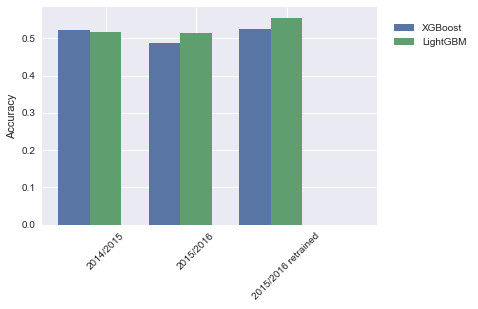

In [60]:
# Football Retrain Results
xgb_metrics = [acc_xgb1, acc_xgb2, acc_xgb2_retrain]
lgbm_metrics =[acc_lgbm1, acc_lgbm2, acc_lgbm2_retrain]
ax = plot_metrics(xgb_metrics, lgbm_metrics)
fig = ax.get_figure()
fig.savefig('football.svg', bbox_inches='tight')